In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from print_array import *
import time
import scipy.optimize as opt

In [3]:

class instrument:
    xmin=0; xmax=100; ymin=0; ymax=100 #boundaries for search
  
    def __init__(self,motorspeed,error,starttime):#s/steps,error for 1s integration time
        self.motorspeed=motorspeed
        self.error=error
        self.starttime=starttime
        self.t=0
        self.pos=np.array([self.xmin+np.random.uniform(0,self.xmax-self.xmin),self.ymin+np.random.uniform(0,self.ymax-self.ymin)])#random position
        self.x1=np.random.uniform(1,90)
        self.x2=np.random.uniform(1,90)
        self.sig1=np.random.uniform(5.0,10.0)
        self.sig2=np.random.uniform(5.0,10.0)
        self.theta=np.random.uniform(0,2*np.pi)
        self.func=lambda x: np.exp(-0.5*((((x[0]-self.x1)*np.cos(self.theta)-(x[1]-self.x2)*np.sin(self.theta))/self.sig1)**2+(((x[0]-self.x1)*np.sin(self.theta)+(x[1]-self.x2)*np.cos(self.theta))/self.sig2)**2))
 
    def scan(self,x,st):#position, scan time
        self.t+=(abs(x[0]-self.pos[0])+abs(x[1]-self.pos[1]))*self.motorspeed+st+self.starttime
        self.pos=np.array(x)
        return self.func(x)+np.random.normal(0,self.error,(1))[0]*(0.1+0.9*st**-.5)
    

MIM_LP_DOAS=instrument(50,0.01,0.5)
print('measurement value at [20,30] for a integaration time of 10s:',MIM_LP_DOAS.scan([20,30],10))


measurement value at [20,30] for a integaration time of 10s: -0.002776347381534344


time needed for search: 0.06137228012084961
maximum of1.2180913319771398found atmaxxpos	maxypos
best scantime: [0.01]	best stepsize: 1


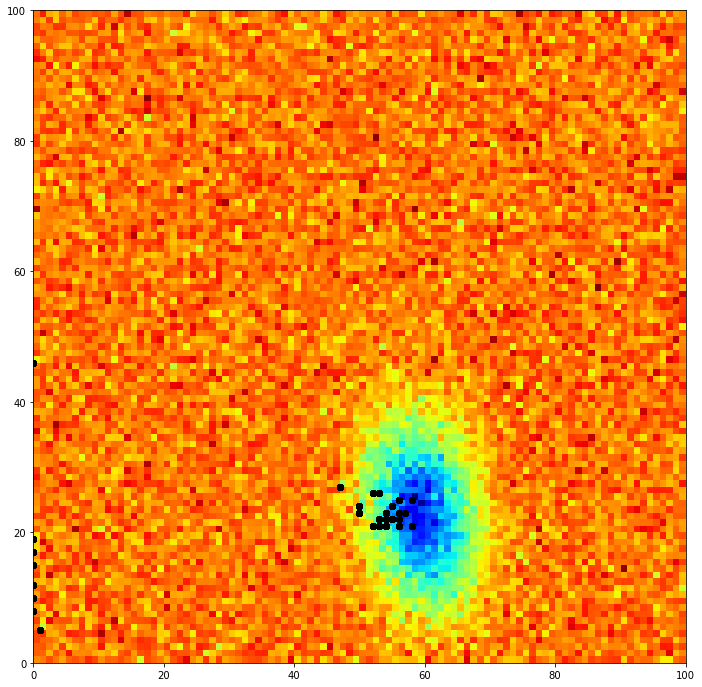

In [16]:
instr = instrument(50,0.01,0.5)

acc = 1.0
scantime = np.arange(0.01,1,99) 
stepsize = np.arange(1,10,1)

show = True

nx = (instr.xmax-instr.xmin)/acc
ny = (instr.ymax-instr.ymin)/acc

func_grid = np.zeros((int(nx),int(ny)))

for i in np.arange(nx): 
    for j in np.arange(ny):
        func_grid[int(i),int(j)] = instr.scan([int(instr.xmin+acc*i),int(instr.ymin+acc*j)], scantime)

fig, axs = plt.subplots(1,1,figsize=(12,12))
 
searchtime = 100
    
for k in scantime:
    for l in stepsize:
        t0 = time.time()

        maxxpos = int(instr.xmin);
        maxypos = int(instr.ymin);

        err = 0.05

        for i in np.arange(instr.xmin,instr.xmax,acc):
            for j in np.arange(instr.ymin,instr.ymax,acc):
                if (func_grid[int(i),int(j)]>func_grid[maxxpos,maxypos]):
                    maxxpos=int(i);
                    maxypos=int(j);
                    maxval = func_grid[maxxpos,maxypos];
                    if show:
                        plt.scatter(maxxpos,maxypos,color='black')

        t1 = time.time()
        
        if(t1-t0 < searchtime): 
            searchtime = t1-t0
            best_scantime = k
            best_stepsize = l

print('time needed for search: ' + str(searchtime))
print('maximum of' + str(maxval) + 'found at' + 'maxxpos\t' + 'maxypos')
print('best scantime: ' + str(scantime) + '\tbest stepsize: ' + str(best_stepsize))

if show:
    plt.imshow(func_grid.T[::-1,:], interpolation = 'nearest',cmap='jet_r', extent=[instr.xmin,instr.xmax,instr.ymin,instr.ymax])
    plt.show()


In [34]:
def calc_std(n, st):
    instr_std = instrument(1,.05,0)
    measure = np.zeros(n)
    for i in range(n):
        measure[i] = instr_std.scan([20,30], st)
    std = measure.std()
    return std

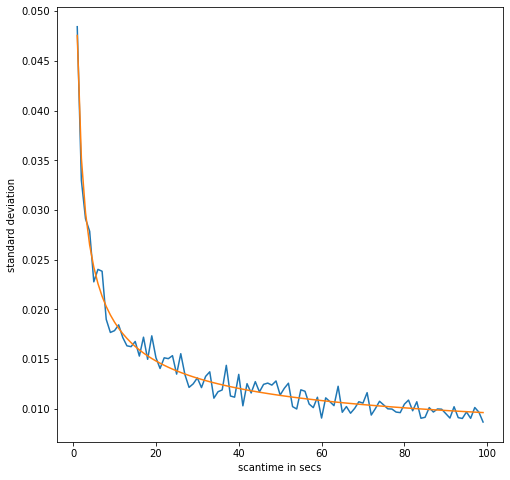

C1 = 0.005399664821930347	C2 = 0.0421414794811612


In [37]:
scantimes = np.arange(1,100,1)
stds = np.zeros(len(scantimes))
for i in scantimes:
    stds[i-1] = calc_std(100,i)
    
#fit the following function f(t) = c1 + c2/sqrt(t)

fit_func = lambda t, c1, c2 : c1 + c2 / np.sqrt(t)
opt_param, opt_cov = opt.curve_fit(fit_func, scantimes, stds)

plt.figure(figsize=(8,8))
plt.plot(scantimes, stds, label = 'standard deviation')
plt.plot(scantimes, fit_func(scantimes, opt_param[0], opt_param[1]), label = 'fitted curve') 
plt.ylabel('standard deviation')
plt.xlabel('scantime in secs')
plt.show()

print('C1 = ' + str(opt_param[0]) + '\tC2 = ' + str(opt_param[1]))

**Better Search Algorithm**

In [ ]:
instr_search = instrument(1,.05,0)
xmax = instr_search.xmax
ymax = instr_search.ymax
xmin = instr_search.xmin
ymin = instr_search.ymin
step_initial = xmax / 4
step = step_initial
maximum = 0

for i in range(shape_points):
    

In [ ]:
def construct_coords(xmin, xmax, ymin, ymax, step):
    coords = np.zeros((xmax/step-1,xmax/step-1))
    
    for i in range(coords.shape[0]):
        for j in range(coords.shape[0]):
            coords[i,j] = (i+1)*step